<a href="https://colab.research.google.com/github/pachterlab/Clytia_single_cell_2020/blob/master/notebooks/CellAtlasAnalysis/pseudotime_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Wed Aug 19 16:45:58 UTC 2020


In [1]:
#Read in kallisto bus fed/starved data
!wget --quiet https://caltech.box.com/shared/static/glwk0aln8a3osfuffab73a47js8n0f4w

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
!wget --quiet https://caltech.box.com/shared/static/3l60szs0e9hgaax4q9dbuehgoo092xww

In [2]:
#Previously saved neuron subpopulations
!wget --quiet https://caltech.box.com/shared/static/pxsxk2l24jsmsxx03nkd4isj9a2fk7ek

#Previously saved neuron pseudotime adata
!wget --quiet https://caltech.box.com/shared/static/xfxwlpnsjcku6qdcspndpqb4qylui37f

#Previously saved nematocyte pseudotime adata
!wget --quiet https://caltech.box.com/shared/static/p56xrl05gdgmtm2esnxat5soxeh9sg4g

In [3]:
#Human ortholog annotations
!wget --quiet https://caltech.box.com/shared/static/slxs7968tths1xotumohnzwy6pgdtk6k

#Panther annotations
!wget --quiet https://caltech.box.com/shared/static/vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt

#GO Terms
!wget --quiet https://caltech.box.com/shared/static/0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof

In [4]:
#Previously saved pseudotime genes

#Nematocyte trajectory (ranked genes)
!wget --quiet https://caltech.box.com/shared/static/u19vzppejvt6ky3ysqptt2ia2dqozpkf

#Neuron trajectory (ranked genes)
!wget --quiet https://caltech.box.com/shared/static/ippfug3xt20etmyx08egzpipgmyfc17m

In [5]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy
!pip3 install --quiet leidenalg

!pip install --quiet louvain

     |████████████████████████████████| 122kB 4.3MB/s 
     |████████████████████████████████| 7.7MB 5.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 2.4MB 3.5MB/s 
     |████████████████████████████████| 3.2MB 31.6MB/s 
     |████████████████████████████████| 2.2MB 4.3MB/s 


###**Import Packages** 

In [6]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")


In [7]:
#Read in annotation data
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('slxs7968tths1xotumohnzwy6pgdtk6k'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]
#hg_ortho_df.head()

panther_df = pd.read_csv('vx2iztm7tsyvg7rcj93h2w3hhjhn7jnt',
            sep="\t",header=None) #skiprows=[0,1,2,3]

#panther_df.head()

goTerm_df = pd.read_csv('0ly6k9iwo1nc9dp5zxo8sw7qe0gt4oof',
            sep=" ",header=None) #skiprows=[0,1,2,3]

#goTerm_df.head()

In [8]:
#Read in saved data
bus_fs_combo = anndata.read('glwk0aln8a3osfuffab73a47js8n0f4w')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('3l60szs0e9hgaax4q9dbuehgoo092xww')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)

neuron_subpops  = anndata.read('pxsxk2l24jsmsxx03nkd4isj9a2fk7ek') 
print(neuron_subpops)

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'
AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch',

In [9]:
#Functions used

#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
def runRegr_dptPseudotime(adata,adata_scaled,label='dpt_pseudotime'):
  X = adata.X
  if scipy.sparse.issparse(X):
    X = X.toarray()
  
  #80% training data
  perc = 0.8
  n = np.int(perc*X.shape[0])

  np.random.seed(0)
  indices = np.random.choice(X.shape[0], n, replace=False,)
  X_train = X[indices,:]

  y = adata_scaled.obs[label]
  y_train = y[indices]

  X_test = X[[i for i in range(0,X.shape[0]) if i not in indices],:]
  y_test = y[[i for i in range(0,X.shape[0]) if i not in indices]]

  regr = RandomForestRegressor(random_state=42,max_samples=perc)
  regr.fit(X_train, y_train)
  print(regr.score(X_test, y_test))
  result = permutation_importance(regr, X_test, y_test, n_repeats=5, random_state=42)
  
  return result

#Convert filtered results to dataframe
def resToDF(result,adata):
  neur_gene_res = pd.DataFrame()
  neur_gene_res['Genes'] = adata.var_names
  neur_gene_res['Mean'] = result.importances_mean
  neur_gene_res['Std'] = result.importances_std

  neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

  neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

  print(len(neur_gene_res.Genes))

  return neur_gene_res

#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

#Order cells in cell-by-gene matrix by pseudotime
def orderTime(adata):
  sortTime = np.argsort(adata.obs['dpt_pseudotime'])
  newNames = adata.obs_names[list(sortTime)]

  adataRet = adata[newNames,:]
  return adataRet


###**I-cells, Neurons, Nematocytes**

In [10]:
#Subset data

#I-cells, neurons, nematocytes
big_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23])]


sc.pp.filter_cells(big_lin, min_counts=0)
sc.pp.filter_genes(big_lin, min_counts=1)
sc.pp.normalize_per_cell(big_lin, counts_per_cell_after=1e4)

big_lin_copy = big_lin.copy()
sc.pp.log1p(big_lin)

big_lin.raw = sc.pp.log1p(big_lin_copy, copy=True)


sc.pp.highly_variable_genes(big_lin, n_top_genes=4000,n_bins=50)

big_lin = big_lin[:,big_lin.var['highly_variable']]

big_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4064 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'

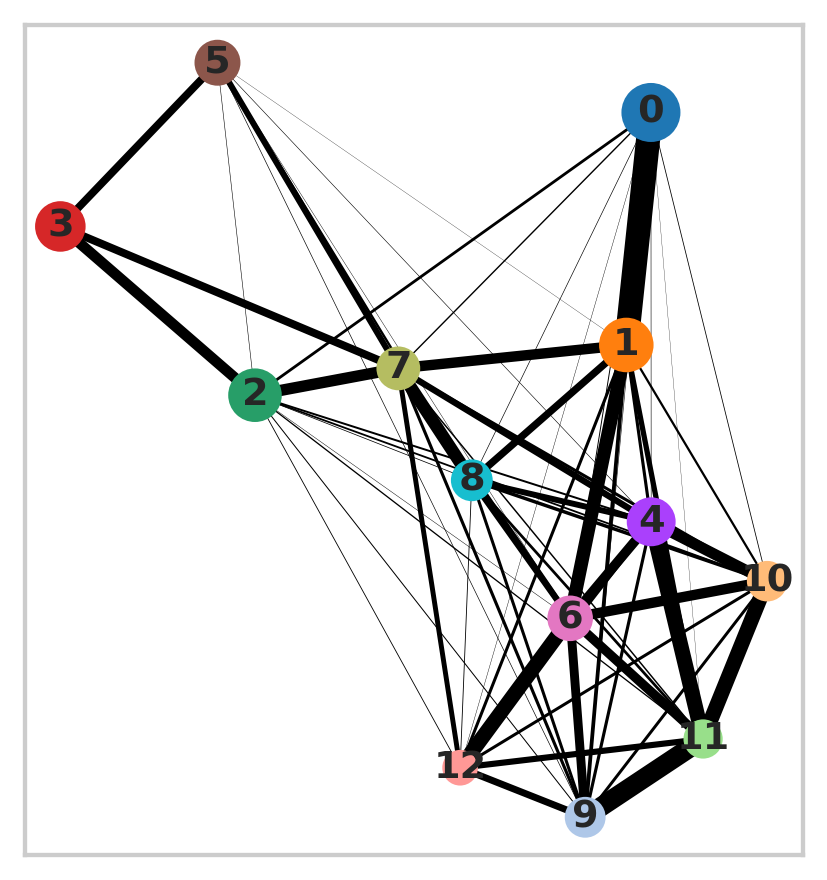

In [11]:
#Large lineage PAGA embedding

big_lin_scaled = big_lin
sc.pp.scale(big_lin_scaled, max_value=10)

sc.tl.pca(big_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(big_lin_scaled,n_neighbors=50, n_pcs=15,method='gauss')

sc.tl.louvain(big_lin_scaled,resolution=1,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(big_lin_scaled, groups='louvain_test',)
sc.pl.paga(big_lin_scaled, color=['louvain_test'])

In [12]:
#Add neuron subpopulation labels
labels = []
for c in big_lin_scaled.obs_names:
  if c in neuron_subpops.obs_names:

    labels += [neuron_subpops[c,:].obs['louvain_neur'][0]]
  else:
    labels += ['rest']

big_lin_scaled.obs['louvain_neur'] = pd.Categorical(labels)

In [13]:
sc.tl.draw_graph(big_lin_scaled, init_pos='paga')
#sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','louvain_neur','cellRanger_louvain','fed'], legend_loc='on data',color_map='viridis',alpha=0.5)

In [14]:
#Calculate pseudotime with diffusion components (dim reduction)

big_lin_scaled.uns['iroot'] = np.flatnonzero(big_lin_scaled.obs['louvain_test']  == '0')[0]
sc.tl.diffmap(big_lin_scaled,n_comps=10)
sc.tl.dpt(big_lin_scaled,n_dcs=10)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


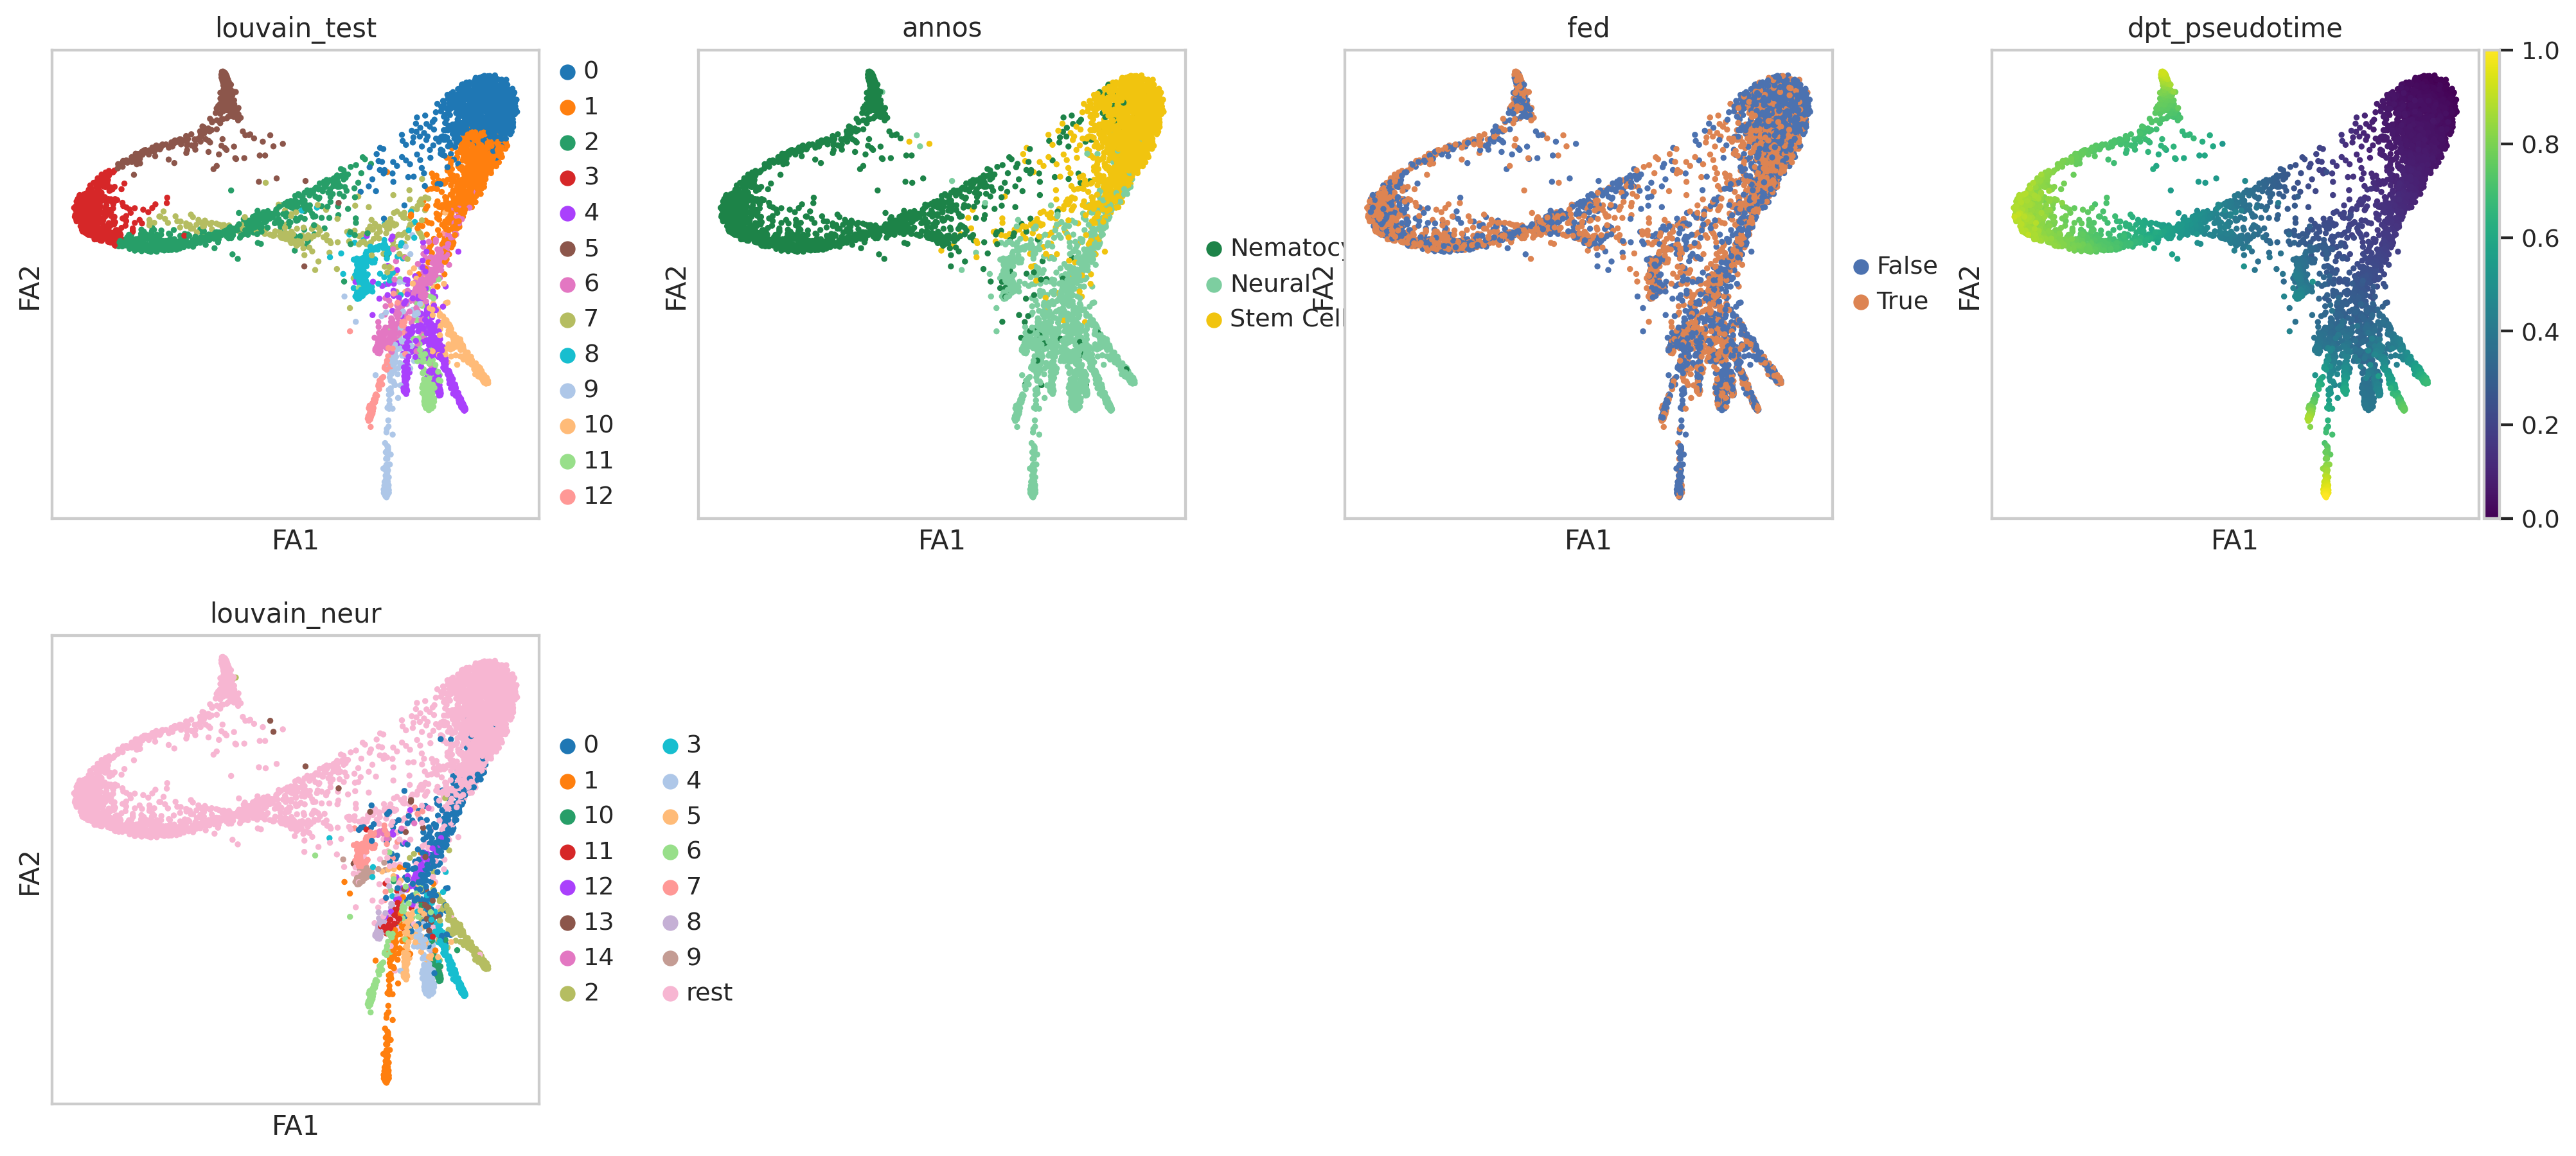

In [15]:
sc.pl.draw_graph(big_lin_scaled, color=['louvain_test','annos','fed','dpt_pseudotime','louvain_neur'], 
                 color_map='viridis') #legend_loc='on data'

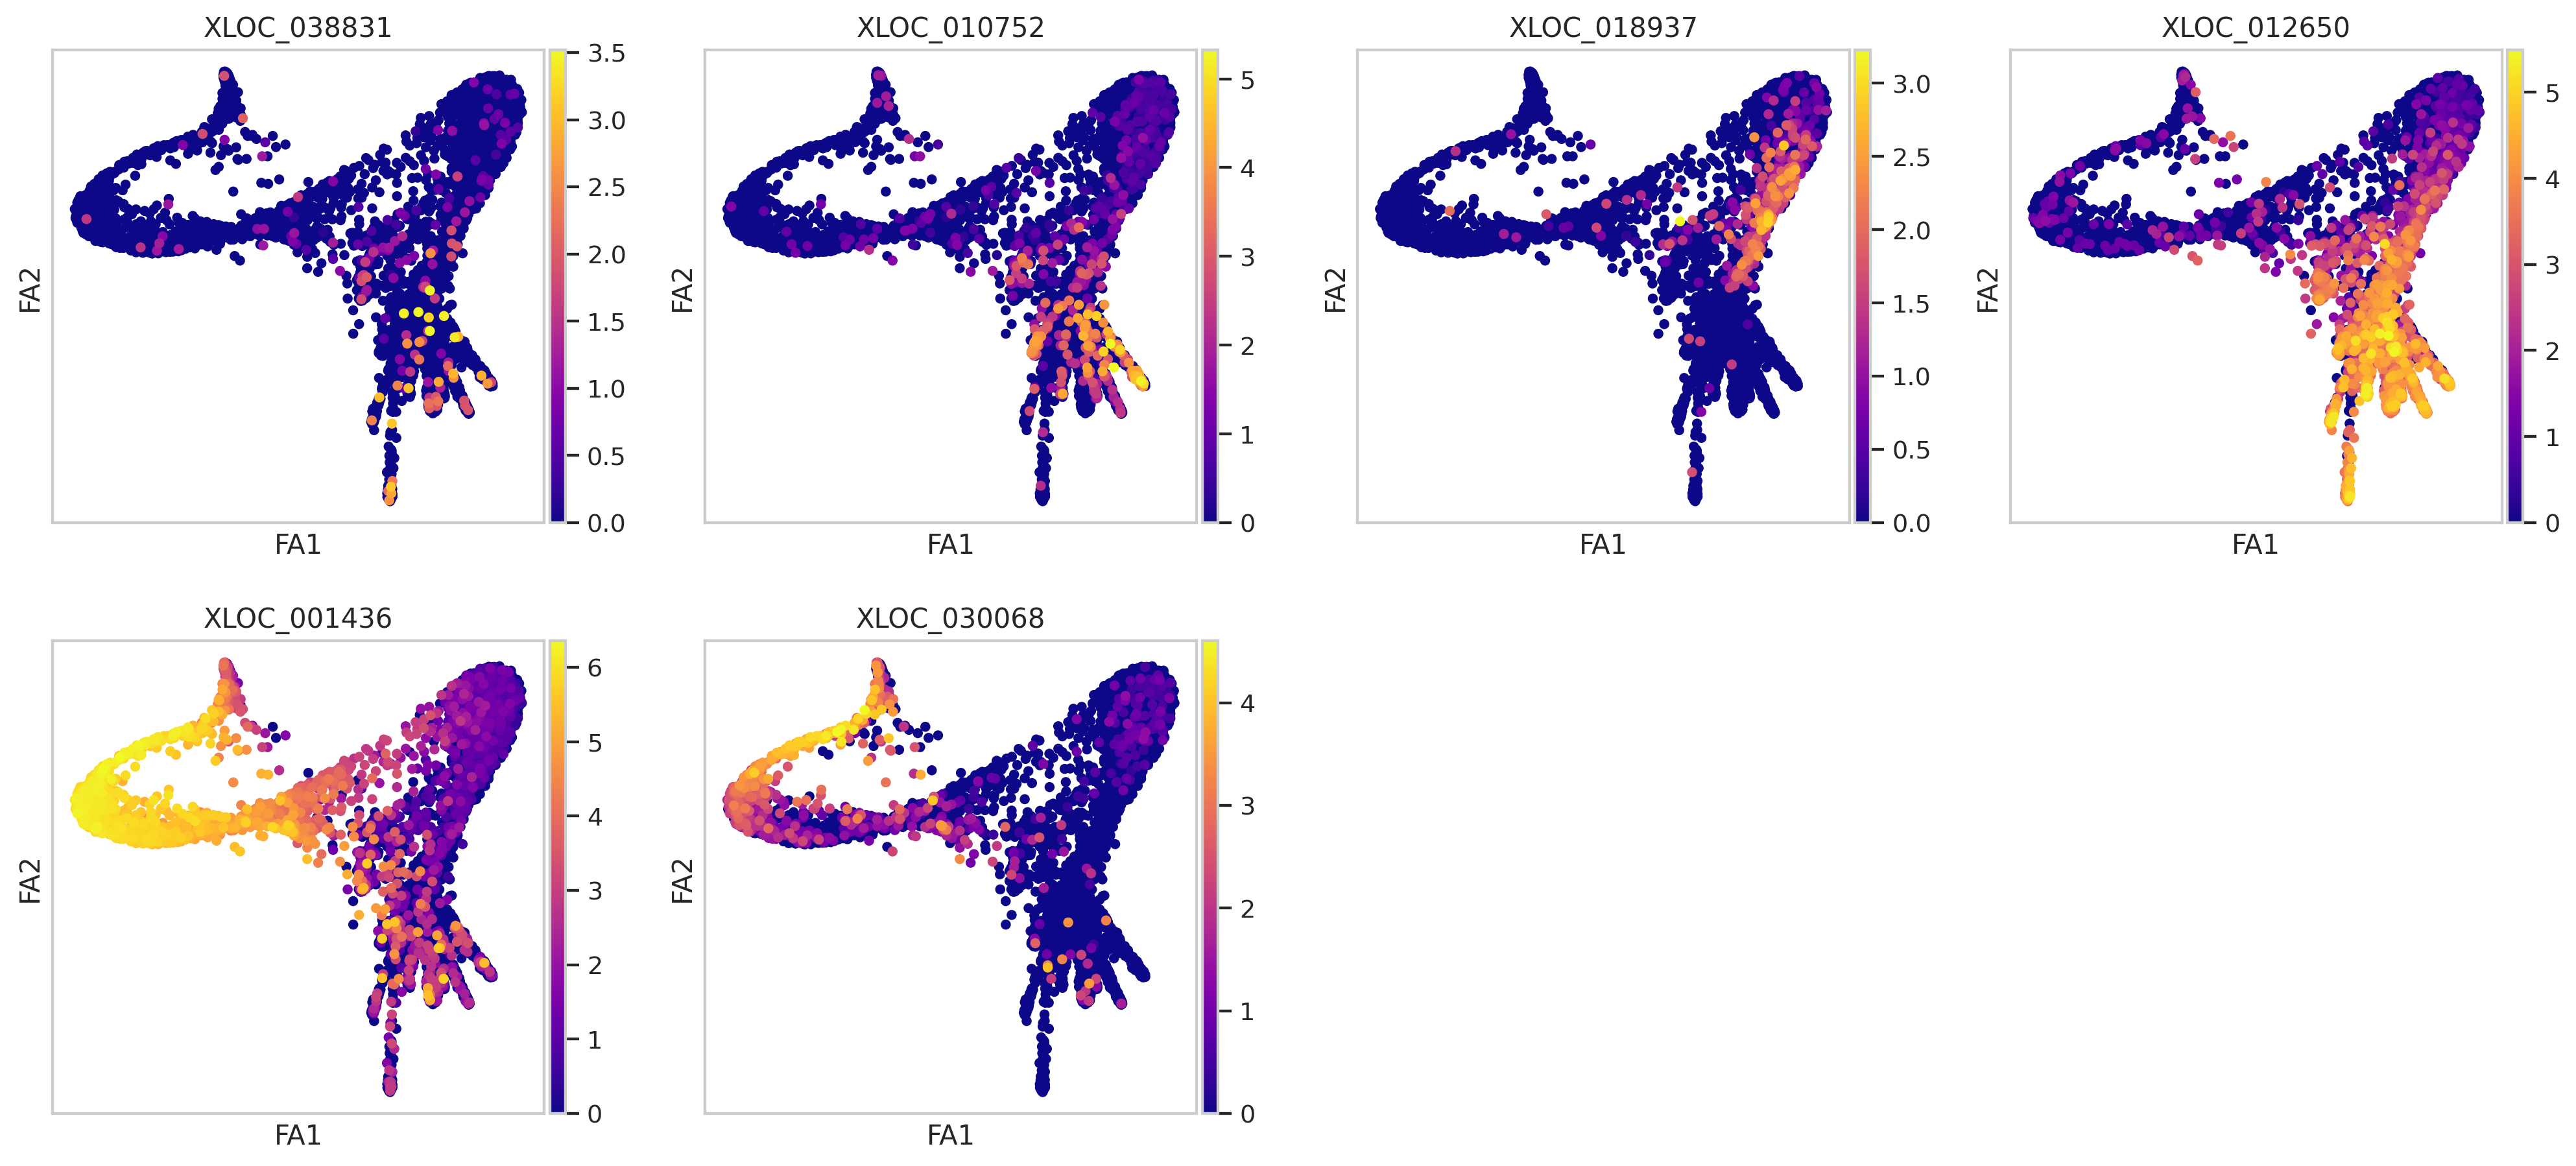

In [16]:
sc.pl.draw_graph(big_lin_scaled, color=['XLOC_038831','XLOC_010752','XLOC_018937','XLOC_012650','XLOC_001436','XLOC_030068'], 
                 legend_loc='on data',color_map='plasma',s=80) 

In [17]:
#Make adata for doing regression (more variable genes included)
big_lin_reg = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,11,12,17,23])]


sc.pp.filter_cells(big_lin_reg, min_counts=0)
sc.pp.filter_genes(big_lin_reg, min_counts=1)
sc.pp.normalize_per_cell(big_lin_reg, counts_per_cell_after=1e4)

big_lin_copy = big_lin_reg.copy()
sc.pp.log1p(big_lin_reg)

big_lin_reg.raw = sc.pp.log1p(big_lin_copy, copy=True)

#For shorter demonstration use 4000 option
#sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=4000,n_bins=10)
sc.pp.highly_variable_genes(big_lin_reg, n_top_genes=15000,n_bins=10) 

big_lin_reg = big_lin_reg[:,big_lin_reg.var['highly_variable']]


Trying to set attribute `.obs` of view, copying.


In [18]:
#Convert pseudotime valeus to quantiles of pseudotime 
big_lin_reg.obs['dpt_pseudotime'] = big_lin_scaled.obs['dpt_pseudotime']

nbins = 20 #quantiles
rangeList = range(0,nbins)
strList = [str(i) for i in rangeList]

cnido = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,11,12,17,23])]
cnido.obs['quantTimeBlocks'] = pd.qcut(cnido.obs['dpt_pseudotime'],q=nbins,labels=strList)

neuro = big_lin_reg[big_lin_reg.obs['cellRanger_louvain'].isin([0,26,31,9,6])]
neuro.obs['quantTimeBlocks'] = pd.qcut(neuro.obs['dpt_pseudotime'],q=nbins,labels=strList)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [19]:
cnido.write('nemato.h5ad')
neuro.write('neuro.h5ad')

In [20]:
big_lin_scaled

AnnData object with n_obs × n_vars = 4064 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts', 'louvain_test', 'louvain_neur', 'dpt_pseudotime'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'paga', 'louvain_test_sizes', 'louvain_test_colors', 'draw_graph', 'iroot', 'diffmap_evals', 'fed_colors', 'louvain_neur_colors'
    obsm: 'X_pca', 'X_draw_graph_fa', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#Create embedding for plotting pseudotime genes
big_lin_reg.uns['paga'] = big_lin_scaled.uns['paga'] 

big_lin_reg.uns['draw_graph'] = big_lin_scaled.uns['draw_graph']

big_lin_reg.obsm['X_draw_graph_fa'] = big_lin_scaled.obsm['X_draw_graph_fa']


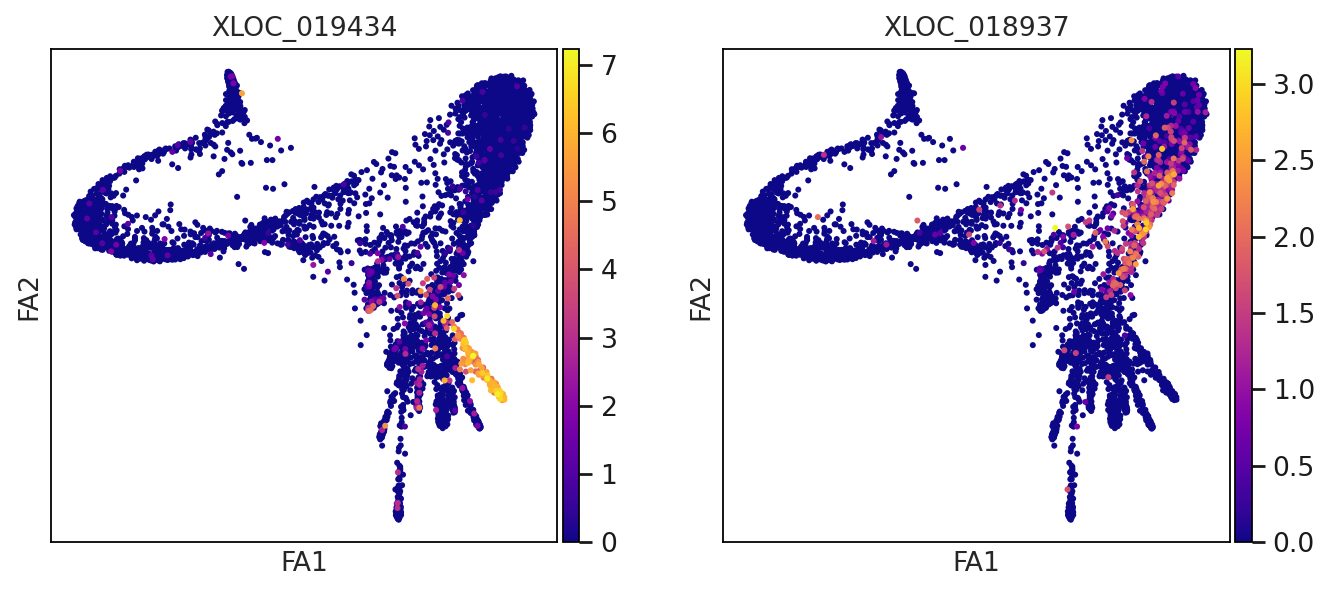

In [29]:
sc.pl.draw_graph(big_lin_reg, color=['XLOC_019434','XLOC_018937'], 
                 legend_loc='on data',color_map='plasma') 

In [ ]:
big_lin_reg.write('pseudoEmbed_fullLineage.h5ad')

#### **Run Regression**
Will take a while. Can plot with saved results instead of re-running model or run with less genes

In [ ]:
#Run regression

result_cnido = runRegr_dptPseudotime(cnido,cnido,'quantTimeBlocks')
result_neuro = runRegr_dptPseudotime(neuro,neuro,'quantTimeBlocks')

0.9252565851716389
0.8683961569750528


In [ ]:

#Make dataframe from regression results
cnido_gene_res = resToDF(result_cnido,cnido)
neuro_gene_res = resToDF(result_neuro,neuro)


2202
2186


In [ ]:
cnido_gene_res = annotateResDF(cnido_gene_res)
neuro_gene_res = annotateResDF(neuro_gene_res)
cnido_gene_res.head()

Genes  ...                                            goTerms
629    XLOC_001436  ...                                              [nan]
631    XLOC_001437  ...                                                 NA
3242   XLOC_008048  ...  [GO:0032502,GO:0016337,GO:0007398,GO:0007498,G...
7688   XLOC_021750  ...  [GO:0000910,GO:0005856,GO:0005200,GO:0006897,G...
12680  XLOC_039385  ...  [GO:0016787,GO:0005615,GO:0044238,GO:0019538,G...

[5 rows x 8 columns]

In [ ]:
cnido_gene_res.to_csv('cnido_stem_lineage_pseudotime_genes.csv')
neuro_gene_res.to_csv('neuro_stem_lineage_pseudotime_genes.csv')

#### **Plot Results of Regression**

In [22]:
def returnVal(i):
  if i == i:
    i= i.replace("[","")
    i = i.replace("]","")
    i= i.replace("'","")
    i = i.replace("'","")
    return i 
  else:
    return 'nan'

neuro_gene_res = pd.read_csv('ippfug3xt20etmyx08egzpipgmyfc17m')
print(neuro_gene_res.head())

cnido = anndata.read('p56xrl05gdgmtm2esnxat5soxeh9sg4g')
neuro = anndata.read('xfxwlpnsjcku6qdcspndpqb4qylui37f')
print(neuro)



   Unnamed: 0  ...                                            goTerms
0        8941  ...                                                NaN
1        4963  ...                                                NaN
2        4295  ...                                              [nan]
3        4164  ...                                              [nan]
4       10102  ...  ['GO:0006996,GO:0044238,GO:0005622,GO:0032991,...

[5 rows x 9 columns]
AnnData object with n_obs × n_vars = 2662 × 14999
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts', 'dpt_pseudotime', 'quantTimeBlocks'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'


Plot expression of genes of interest over time

In [23]:
#Order cells by pseudotime (0 --> 1)
orderCnido = orderTime(cnido)
orderNeuro = orderTime(neuro)

In [24]:
#Plot interesting genes from ranking over time
neuroPeps = ['XLOC_042761','XLOC_019434','XLOC_017097','XLOC_030120']
n_names = ['*PP1','*PP5','*PP11','PP17']

early = ['XLOC_038831','XLOC_041836','XLOC_010226','XLOC_041854','XLOC_045448'] #'XLOC_041854','XLOC_045448'

e_names = ['Semaphorin','NACA2','aGPCR 3','LRR protein 1','LRR protein 2']

late = ['XLOC_034623','XLOC_008333','XLOC_040506','XLOC_012560','XLOC_044075',
        'XLOC_043514','XLOC_034910','XLOC_001206',
        'XLOC_003576','XLOC_002941','XLOC_008328','XLOC_044176','XLOC_017070'] #'XLOC_034910','XLOC_040506'

l_names = ['SIX6','ACTR3','CAB39','Unknown4','ASNS',
           'POLR1A','NCALD','aGPCR 1',
           'KCNA6','aGPCR 2','TRIO','Unknown5','aGPCR 4']

total = early+neuroPeps+late
total_names = e_names+n_names+l_names


In [25]:
set(neuroPeps).intersection(late)

set()

In [26]:
toAddNeuroDict_Other = {}
for i in range(0,len(total)):
  toAddNeuroDict_Other[total[i]] = total_names[i]

Trying to set attribute `.var` of view, copying.


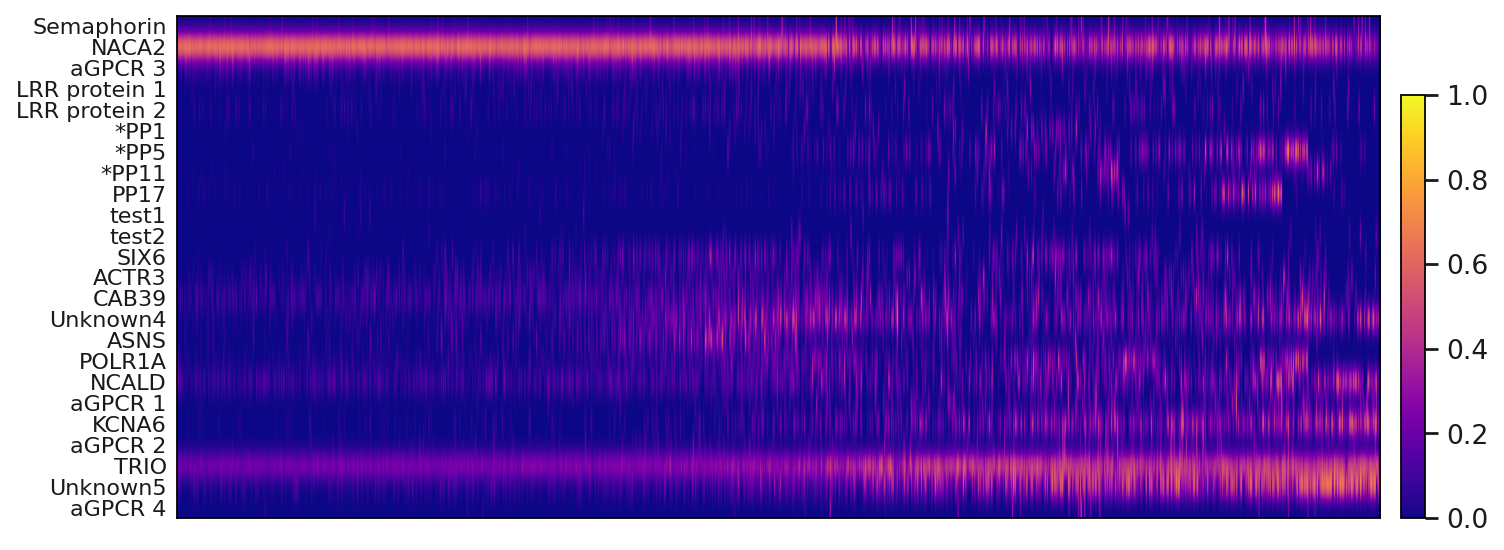

In [27]:
labels= [toAddNeuroDict_Other[i] for i in total]
orderNeuro = orderNeuro[:,total]
orderNeuro.var['names'] = labels


sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderNeuro, total_names, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols= 'names')

##### **Final Pseudotime Plots**

In [ ]:

toAddNeuro = ['XLOC_037011','XLOC_031923','XLOC_010412','XLOC_030920','XLOC_026271','XLOC_025094','XLOC_018937','XLOC_037278','XLOC_009173','XLOC_033489',
                                        'XLOC_010752','XLOC_045293','XLOC_033337','XLOC_012650']
toAddNeuroNames = ['TUBA4A','PCNA','GLUL','bHLH TF 1','DCX','CALR','bHLH TF 2','TAGLN-2','H2AFV','PRDX4',
                          'bHLH TF 3','*SOX-10','CL1','Unknown3']

toAddNeuroDict = {}
for i in range(0,len(toAddNeuro)):
  toAddNeuroDict[toAddNeuro[i]] = toAddNeuroNames[i]


toAddCnido = ['XLOC_001436','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365','XLOC_041836','XLOC_011949','XLOC_015554']
toAddCnidoNames = ['*Mcol3/4','Mcol','*Dkk3','TUBA1C','TF IIIA','NACA2','BOP1','Mos3']
toAddCnidoDict = {}
for i in range(0,len(toAddCnido)):
  toAddCnidoDict[toAddCnido[i]] = toAddCnidoNames[i]



In [ ]:
#Determine where var_names is in list of genesToPlot
allGenes = {**toAddCnidoDict, **toAddNeuroDict}
allGenes = {**allGenes,**toAddNeuroDict_Other}  #'XLOC_002941','XLOC_043514','XLOC_037011','XLOC_040506','XLOC_003576',

forPlotNeuro = ['XLOC_041836','XLOC_026271','XLOC_031923','XLOC_010226',
                'XLOC_018937','XLOC_045293',
                'XLOC_034623','XLOC_040506','XLOC_012560','XLOC_030920','XLOC_010752',
                'XLOC_038831','XLOC_001206','XLOC_042761','XLOC_017097',
                'XLOC_002941','XLOC_030120','XLOC_019434',
                'XLOC_034910','XLOC_012650']


forPlotCnido = ['XLOC_011949','XLOC_011074','XLOC_041836','XLOC_015554','XLOC_041365','XLOC_030068','XLOC_008048','XLOC_001436']



In [ ]:

labelsCnido = [allGenes[i] for i in forPlotCnido]
labelsNeuro = [allGenes[i] for i in forPlotNeuro]

#Order cells by pseudotime (0 --> 1)
orderCnido = orderTime(cnido)
orderNeuro = orderTime(neuro)

orderCnido = orderCnido[:,forPlotCnido]
orderCnido.var['names'] = labelsCnido


orderNeuro = orderNeuro[:,forPlotNeuro]
orderNeuro.var['names'] = labelsNeuro

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


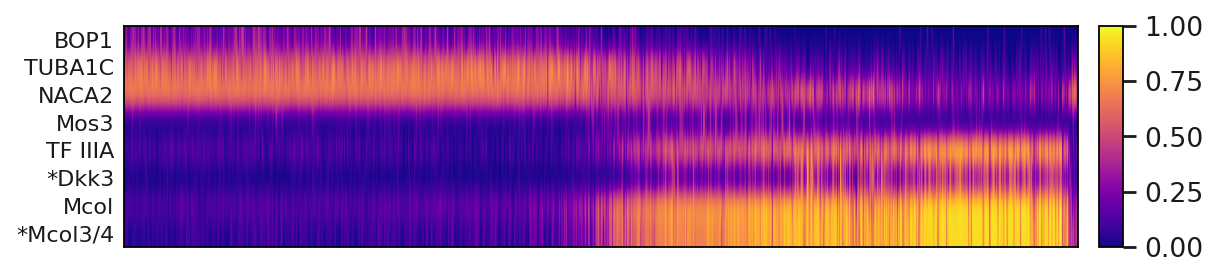

In [ ]:

sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderCnido, labelsCnido, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols='names',figsize=(8,2),
              save='cnido_gauss_BigLinTimeGenes.pdf')

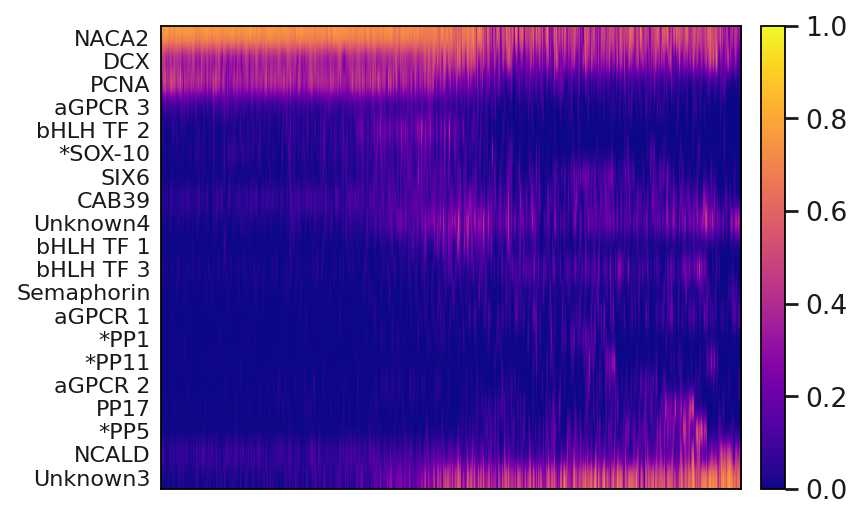

In [ ]:

sc.set_figure_params(scanpy=True, fontsize=12)
sc.pl.heatmap(orderNeuro, labelsNeuro, groupby=None, 
              show_gene_labels=True,use_raw=False,standard_scale='var',
              interpolation='gaussian',cmap='plasma',swap_axes=True,gene_symbols='names',figsize=(5,4),
              save='neuro_gauss_BigLinTimeGenes.pdf')

### **Check gland cell trajectories and/or hair cells**

In [ ]:
#Subset data

#Gland cells: 27,25,32,34,22 + no 31,26,6,9
#Actually including sensory hair cell populations, 5, 10, 21
gland_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([5,10,21,0,11,12,17,23])]


sc.pp.filter_cells(gland_lin, min_counts=0)
sc.pp.filter_genes(gland_lin, min_counts=1)
sc.pp.normalize_per_cell(gland_lin, counts_per_cell_after=1e4)

sc.pp.log1p(gland_lin)


sc.pp.highly_variable_genes(gland_lin, n_top_genes=4000,n_bins=50)

gland_lin = gland_lin[:,gland_lin.var['highly_variable']]

gland_lin



Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4094 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'

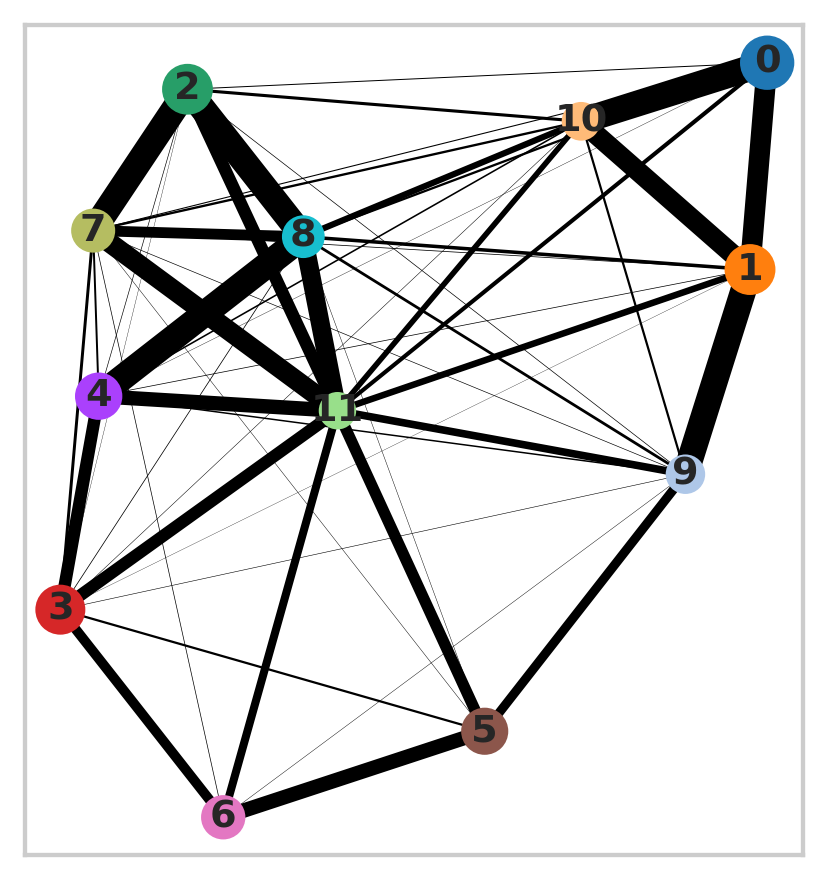

In [ ]:
#Large lineage PAGA embedding

gland_lin_scaled = gland_lin
sc.pp.scale(gland_lin_scaled, max_value=10)

sc.tl.pca(gland_lin_scaled, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(gland_lin_scaled,n_neighbors=100, n_pcs=60,method='gauss')

sc.tl.louvain(gland_lin_scaled,resolution=2,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(gland_lin_scaled, groups='louvain_test',)
sc.pl.paga(gland_lin_scaled, color=['louvain_test'])

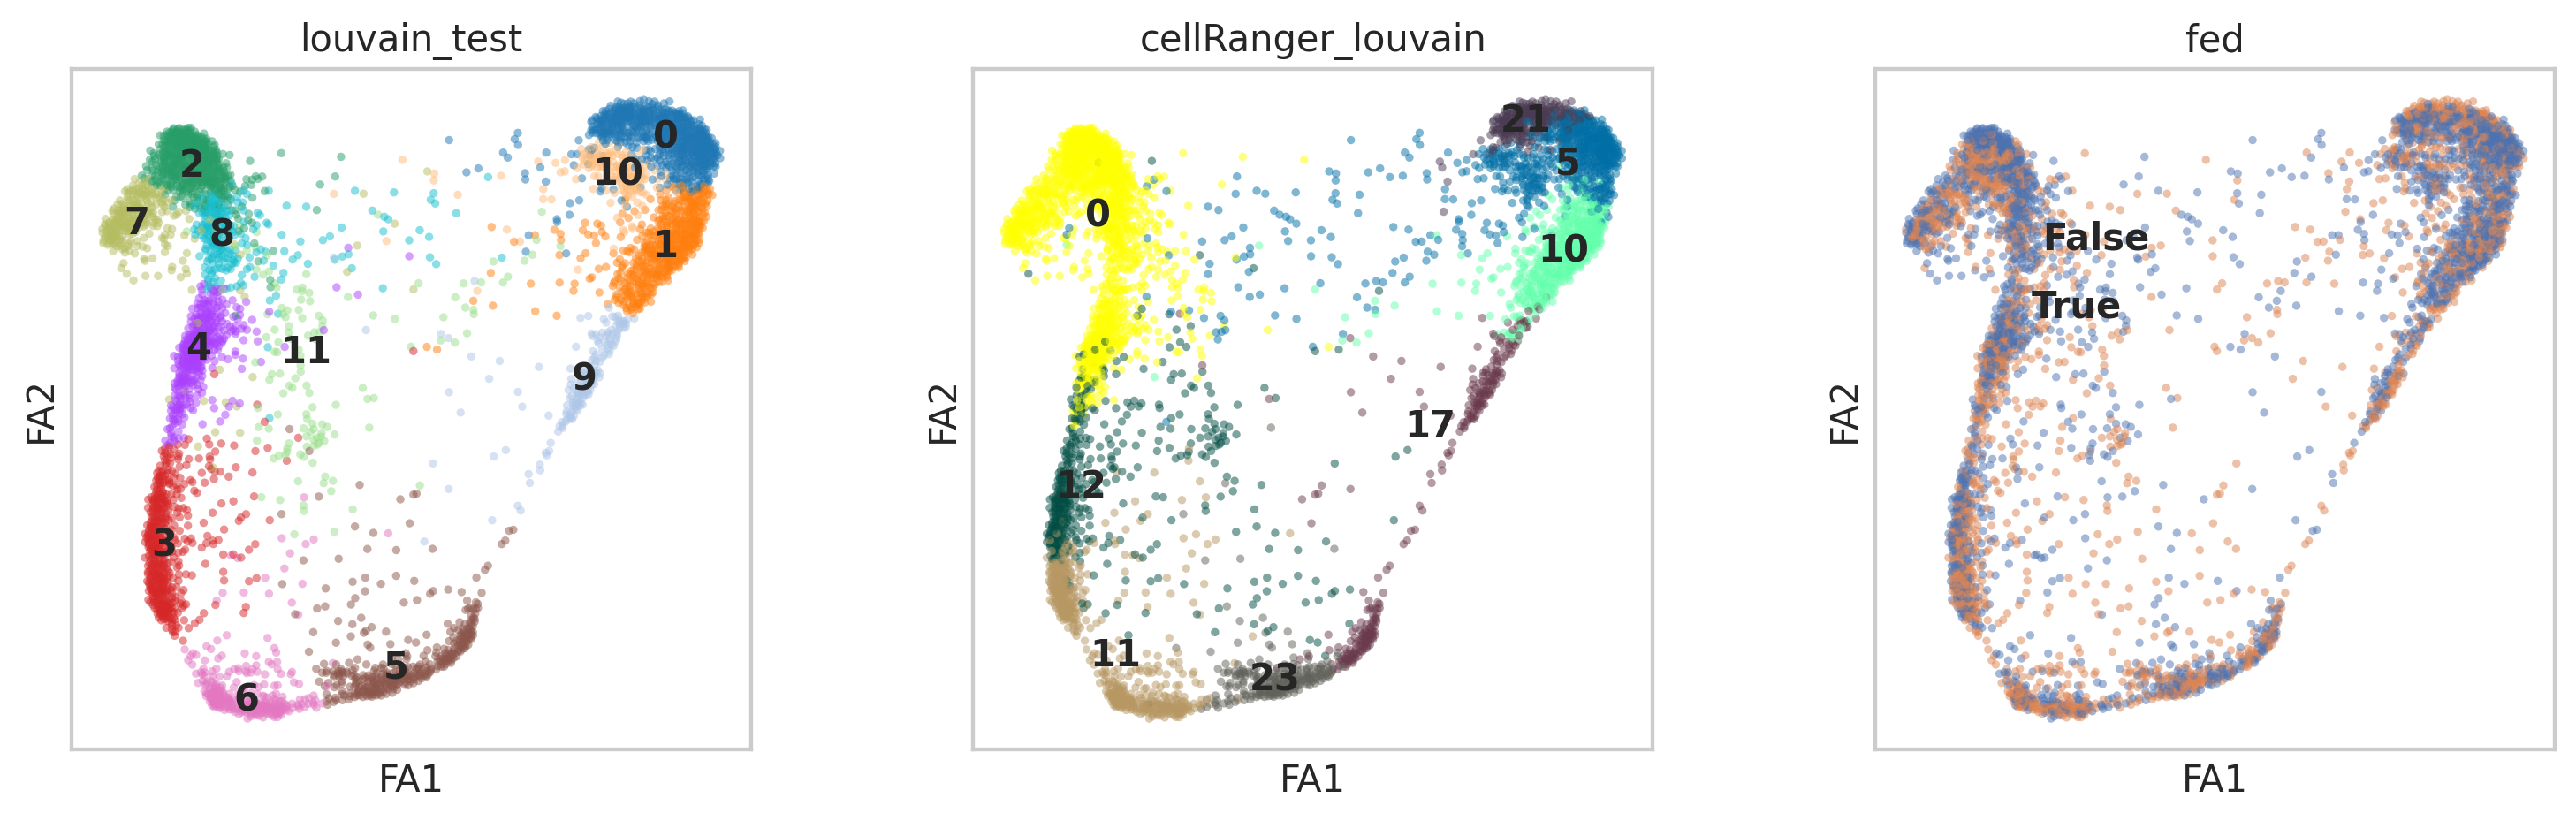

In [ ]:
sc.tl.draw_graph(gland_lin_scaled, init_pos='paga') #'louvain_test'
sc.pl.draw_graph(gland_lin_scaled, color=['louvain_test','cellRanger_louvain','fed'], 
                 legend_loc='on data',color_map='viridis',alpha=0.5)

In [ ]:
#Calculate pseudotime with diffusion components (dim reduction)

gland_lin_scaled.uns['iroot'] = np.flatnonzero(gland_lin_scaled.obs['louvain_test']  == '2')[0]
sc.tl.diffmap(gland_lin_scaled,n_comps=10)
sc.tl.dpt(gland_lin_scaled,n_dcs=10)

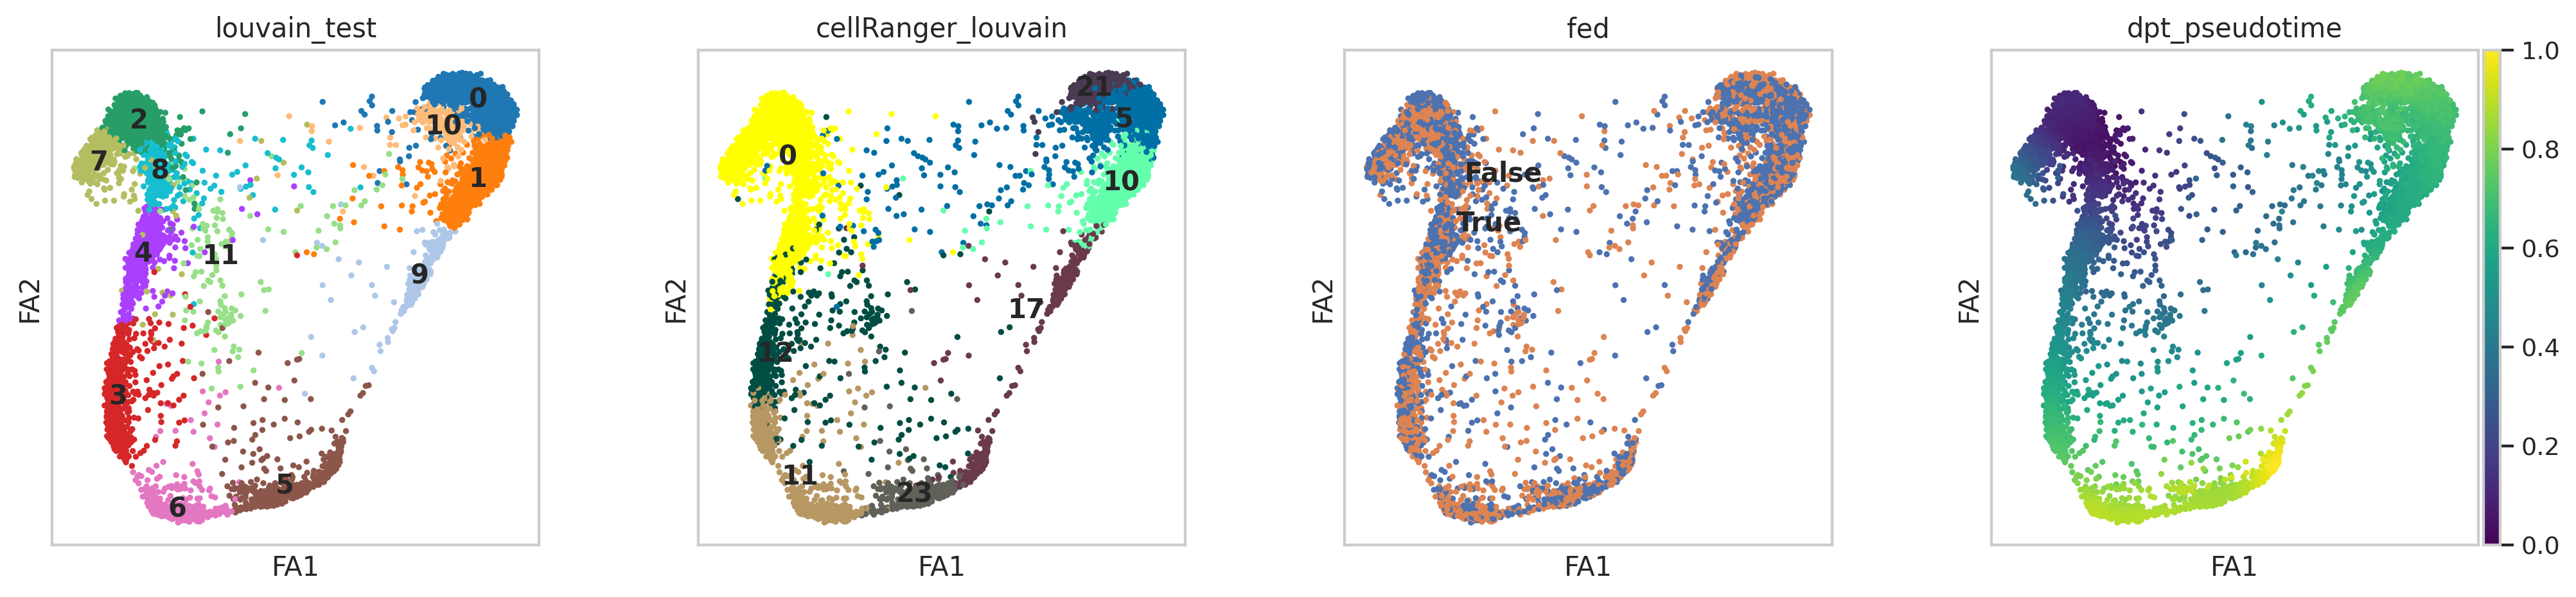

In [ ]:
sc.pl.draw_graph(gland_lin_scaled, color=['louvain_test','cellRanger_louvain','fed','dpt_pseudotime'], 
                 legend_loc='on data',color_map='viridis')

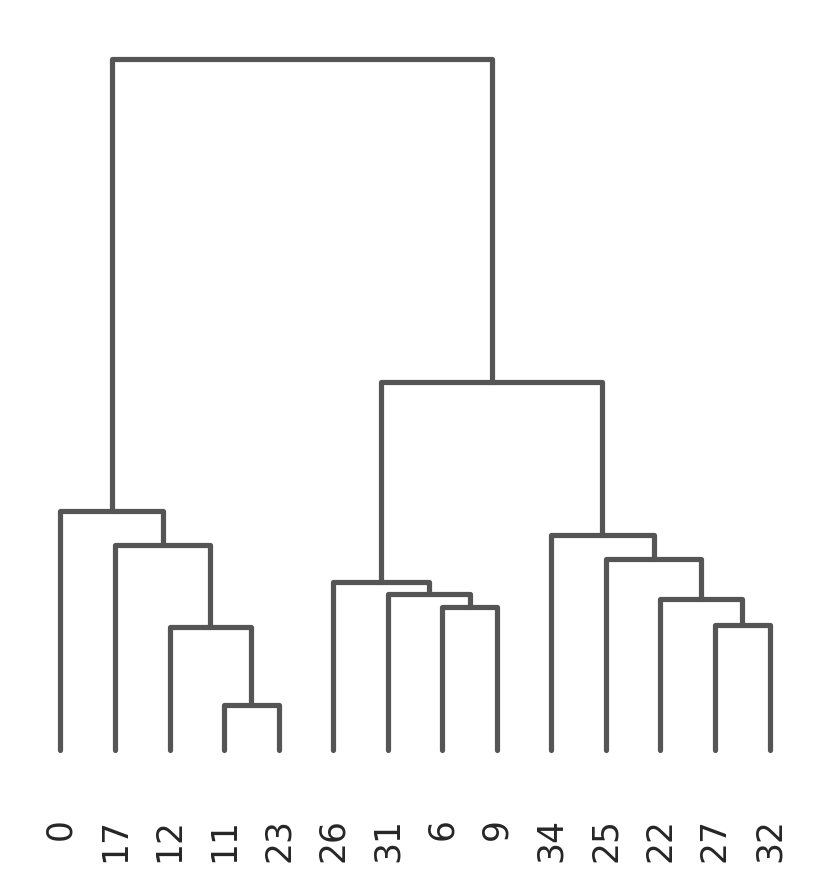

In [ ]:
sc.tl.dendrogram(gland_lin_scaled,'cellRanger_louvain',linkage_method='ward')
gland_lin_scaled.uns['dendrogram_cellRanger_louvain'] = gland_lin_scaled.uns["dendrogram_['cellRanger_louvain']"]
sc.pl.dendrogram(gland_lin_scaled,'cellRanger_louvain')